In [119]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller 
import seaborn as sns 
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA

In [170]:
data=pd.read_csv("craigslist_vehicles.csv")

In [4]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    426880 non-null  int64  
 1   id            426880 non-null  int64  
 2   url           426880 non-null  object 
 3   region        426880 non-null  object 
 4   region_url    426880 non-null  object 
 5   price         426880 non-null  int64  
 6   year          425675 non-null  float64
 7   manufacturer  409234 non-null  object 
 8   model         421603 non-null  object 
 9   condition     252776 non-null  object 
 10  cylinders     249202 non-null  object 
 11  fuel          423867 non-null  object 
 12  odometer      422480 non-null  float64
 13  title_status  418638 non-null  object 
 14  transmission  424324 non-null  object 
 15  VIN           265838 non-null  object 
 16  drive         296313 non-null  object 
 17  size          120519 non-null  object 
 18  type

,Unnamed: 0,id,price,year,odometer,county,lat,long
count,426880.000000,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,213439.500000,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,123229.785793,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,0.000000,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,106719.750000,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,213439.500000,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,320159.250000,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,426879.000000,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


In [5]:
data.isnull().sum()

Unnamed: 0           0
id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
removal_date        68
dtype: int64

In [6]:
# Clean column names (remove leading and trailing spaces)
data=data.drop(columns=["condition",'image_url','paint_color','VIN' ,'cylinders','fuel', 'drive', 'size', 'type', 'description',"region_url"])

In [7]:
data["price"]=pd.to_numeric(data["price"],errors="coerce")
data["posting_date"]=pd.to_datetime(data["posting_date"])
data["removal_date"]=pd.to_datetime(data["removal_date"])



data["posting_date"]=data["posting_date"].dt.tz_localize(None)
data["removal_date"]=data["removal_date"].dt.tz_localize(None)
data["posting_date"]=data["posting_date"].sort_values()
data

,Unnamed: 0,id,url,region,price,year,manufacturer,model,odometer,title_status,transmission,county,state,lat,long,posting_date,removal_date
0,362773,7307679724,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,4500,2002.0,bmw,x5,184000.0,clean,automatic,NaN,tx,32.401556,-99.884713,2021-04-16,2021-05-02
1,362712,7311833696,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,4500,2002.0,bmw,x5,184000.0,clean,automatic,NaN,tx,32.401556,-99.884713,2021-04-24,2021-04-28
2,362722,7311441996,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,4900,2006.0,toyota,camry,184930.0,clean,automatic,NaN,tx,32.453848,-99.787900,2021-04-23,2021-05-25
3,362771,7307680715,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,6500,2008.0,ford,expedition,206000.0,clean,automatic,NaN,tx,32.401556,-99.884713,2021-04-16,2021-04-26
4,362710,7311834578,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,6500,2008.0,ford,expedition,206000.0,clean,automatic,NaN,tx,32.401556,-99.884713,2021-04-24,2021-05-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,303849,7307070484,https://zanesville.craigslist.org/cto/d/zanesv...,zanesville / cambridge,5100,2009.0,NaN,saab 9-7x,106000.0,clean,automatic,NaN,oh,39.937000,-82.031500,2021-04-15,2021-04-21
426876,303706,7314635557,https://zanesville.craigslist.org/cto/d/zanesv...,zanesville / cambridge,7500,2011.0,ford,f-450,177886.0,clean,automatic,NaN,oh,39.927400,-82.004100,2021-04-30,2021-05-15
426877,303704,7314710341,https://zanesville.craigslist.org/cto/d/zanesv...,zanesville / cambridge,25000,2016.0,chevrolet,silverado,78850.0,clean,automatic,NaN,oh,39.896865,-82.042283,2021-04-30,2021-05-12
426878,303670,7316225330,https://zanesville.craigslist.org/cto/d/zanesv...,zanesville / cambridge,6,1986.0,NaN,camaro iroc z28,86500.0,clean,automatic,NaN,oh,39.938630,-82.006760,2021-05-03,2021-05-08


In [ ]:
# plt.figure(figsize=(12, 6))
# plt.scatter(data['year'], data['price'],marker="o")
# plt.title('Price Over Time')
# plt.xlabel('Year')
# plt.ylabel('Price')
# plt.grid(True)

# plt.gca().set_aspect("auto")
# plt.show()


In [8]:
data["year"]

0         2002.0
1         2002.0
2         2006.0
3         2008.0
4         2008.0
           ...  
426875    2009.0
426876    2011.0
426877    2016.0
426878    1986.0
426879    1999.0
Name: year, Length: 426880, dtype: float64

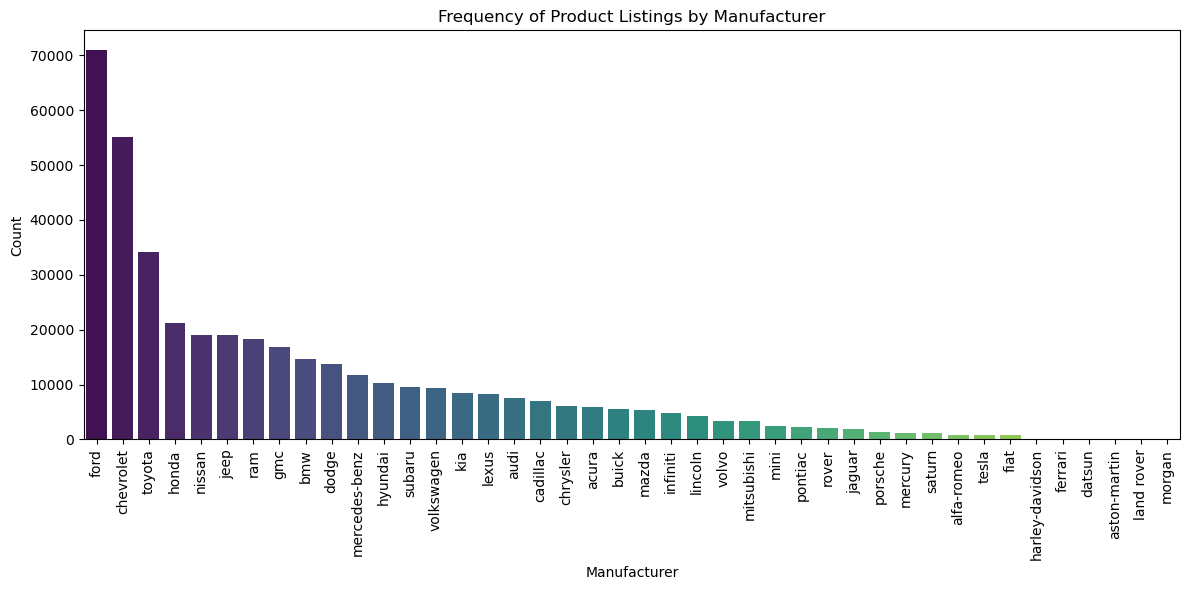

In [9]:
manufacturer = data['manufacturer']
manufacturer = data['manufacturer'].value_counts()

# Create a bar plot to visualize the frequency of each manufacturer
plt.figure(figsize=(12, 6))
sns.barplot(x=manufacturer.index, y=manufacturer.values, palette='viridis')

# Set labels and title
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.title('Frequency of Product Listings by Manufacturer')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

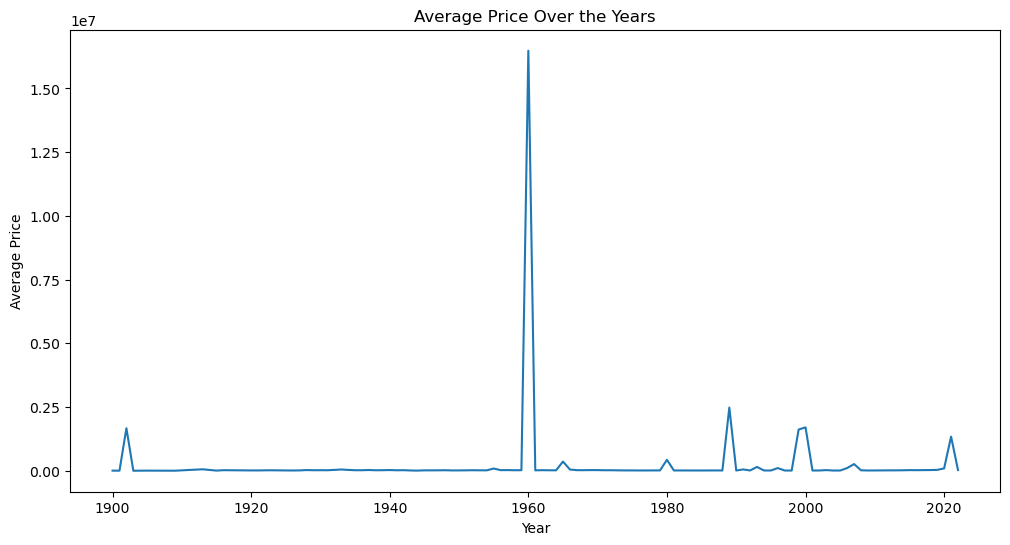

In [10]:

# Grouping data by 'year' and calculating the mean price for each year
mean_price_per_year = data.groupby('year')['price'].mean()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the average price per year
sns.lineplot(data=mean_price_per_year, x=mean_price_per_year.index, y=mean_price_per_year.values, ax=ax)

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Average Price')
ax.set_title('Average Price Over the Years')

# Show the plot
plt.show()



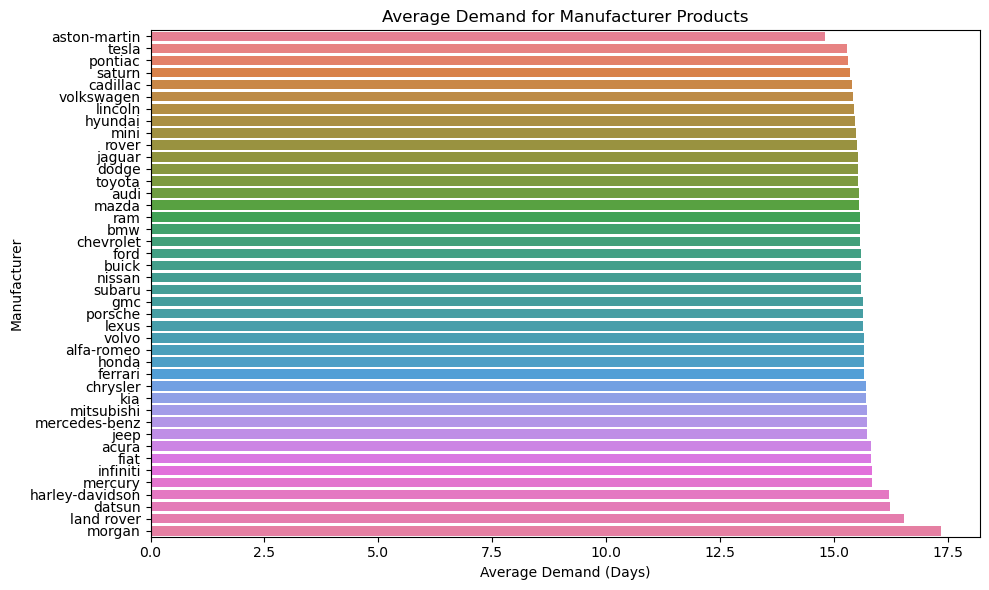

In [11]:

# Calculating the difference between removal date and posting date
data['posting_to_removal_days'] = (data['removal_date'] - data['posting_date']).dt.days

# Group by manufacturer
manufacturer_groups = data.groupby('manufacturer')

# dictionary to store the demand data
demand_data = {'Manufacturer': [], 'Average Demand (Days)': []}

for manufacturer, group in manufacturer_groups:
    average_demand = group['posting_to_removal_days'].mean()

    demand_data['Manufacturer'].append(manufacturer)
    demand_data['Average Demand (Days)'].append(average_demand)

# Create a new DataFrame from the demand data
demand_data = pd.DataFrame(demand_data)

# Sort the DataFrame by average demand
demand_data = demand_data.sort_values(by='Average Demand (Days)')
custom_palette = sns.color_palette("husl", len(demand_data))

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Demand (Days)', y='Manufacturer', data=demand_data, palette=custom_palette)
plt.xlabel('Average Demand (Days)')
plt.ylabel('Manufacturer')
plt.title('Average Demand for Manufacturer Products')
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
#Time analysisfor different products
#TOYOTA
toyota=data[data["manufacturer"].str.lower()=="toyota"].copy()
toyota

toyota["posting_date"]=pd.to_datetime(toyota["posting_date"])
toyota["removal_date"]=pd.to_datetime(toyota["removal_date"])

toyota.sort_values(by="removal_date",inplace=True)
toyota.set_index('removal_date',inplace=True)
toyota

,Unnamed: 0,id,url,region,price,year,manufacturer,model,odometer,title_status,transmission,county,state,lat,long,posting_date,posting_to_removal_days
removal_date,,,,,,,,,,,,,,,,,
2021-04-04,406253,7301721971,https://moseslake.craigslist.org/ctd/d/puyallu...,moses lake,56999,2020.0,toyota,gr supra,14225.0,clean,automatic,NaN,wa,47.199100,-122.315100,2021-04-04,0.0
2021-04-04,377527,7301601318,https://killeen.craigslist.org/ctd/d/killeen-2...,killeen / temple / ft hood,6500,2009.0,toyota,corolla,117747.0,clean,automatic,NaN,tx,31.124479,-97.721092,2021-04-04,0.0
2021-04-04,195334,7301623358,https://battlecreek.craigslist.org/cto/d/battl...,battle creek,21900,2017.0,toyota,prius four,19000.0,clean,automatic,NaN,mi,42.303000,-85.130400,2021-04-04,0.0
2021-04-05,262598,7301657752,https://lascruces.craigslist.org/cto/d/dona-an...,las cruces,25000,2012.0,toyota,tacoma,82500.0,lien,automatic,NaN,nm,32.377071,-106.731148,2021-04-04,1.0
2021-04-05,7693,7302275036,https://anchorage.craigslist.org/ctd/d/anchora...,anchorage / mat-su,31995,2019.0,toyota,highlander,27483.0,clean,automatic,NaN,ak,61.161670,-149.863120,2021-04-05,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-20,129130,7315107363,https://honolulu.craigslist.org/oah/ctd/d/fort...,hawaii,33900,2019.0,toyota,highlander le i4 fwd (natl),11505.0,clean,automatic,NaN,hi,21.344376,-157.896975,2021-05-01,50.0
2021-06-21,275266,7316642021,https://newyork.craigslist.org/stn/cto/d/state...,new york city,3000,2014.0,toyota,camry hybrid,250000.0,clean,automatic,NaN,ny,40.535200,-74.211600,2021-05-04,48.0
2021-06-22,96835,7315870350,https://gainesville.craigslist.org/ctd/d/orlan...,gainesville,8200,2012.0,toyota,scion xb,113897.0,clean,NaN,NaN,fl,28.567037,-81.291542,2021-05-02,51.0


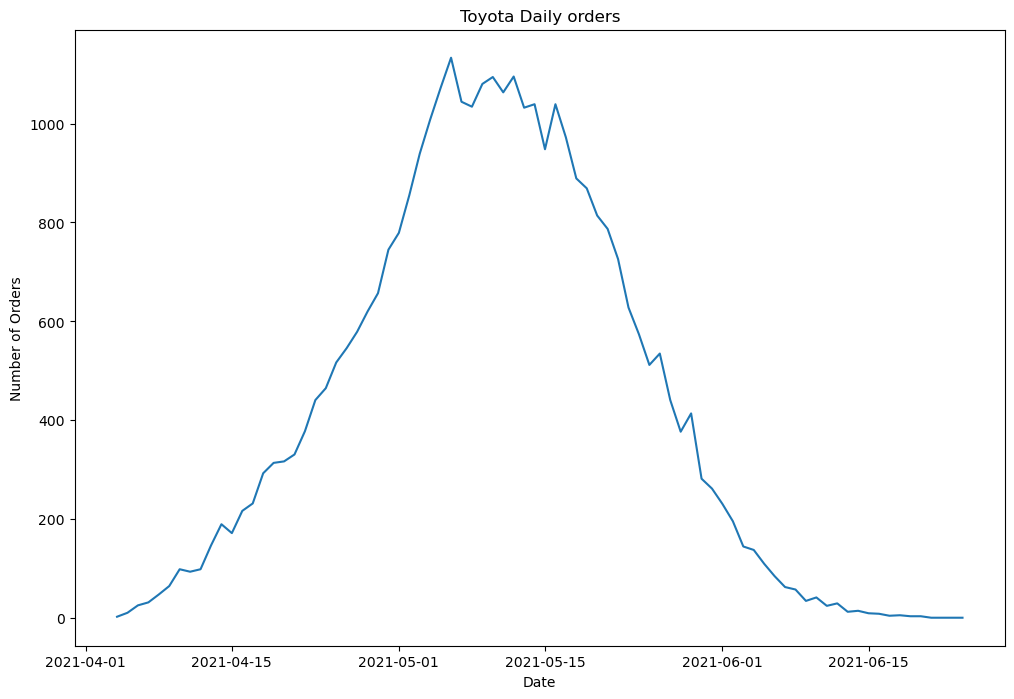

In [13]:
daily=toyota.resample('D').size()
daily.count()


#if the removal of an item signifies its sale then
plt.figure(figsize=(12,8))
plt.plot(daily)
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title('Toyota Daily orders')

plt.show()

In [14]:
#USING ARIMA model forur time seriess analysios
p, d, q = (1, 1, 1)

model = ARIMA(daily, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   82
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -410.192
Date:                Sun, 29 Oct 2023   AIC                            826.384
Time:                        05:57:33   BIC                            833.568
Sample:                    04-04-2021   HQIC                           829.266
                         - 06-24-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9499      0.040     23.888      0.000       0.872       1.028
ma.L1         -0.7599      0.086     -8.798      0.000      -0.929      -0.591
sigma2      1454.7389    176.676      8.234      0.0

C:\New folder\CONDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\New folder\CONDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [15]:
#stationary chcek
st=adfuller(daily)
print("statistic:{st[0]}")
print('value:{st[1]}')  
print(st)

difference = toyota['price'].diff().dropna()

# Perform the ADF test on the differenced data
result = adfuller(difference)

# Extract the p-value from the result
p_value = result[1]
#rint(p_value)


statistic:{st[0]}
value:{st[1]}
(-2.373706337400319, 0.14929552114758798, 5, 76, {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}, 706.3689098251964)


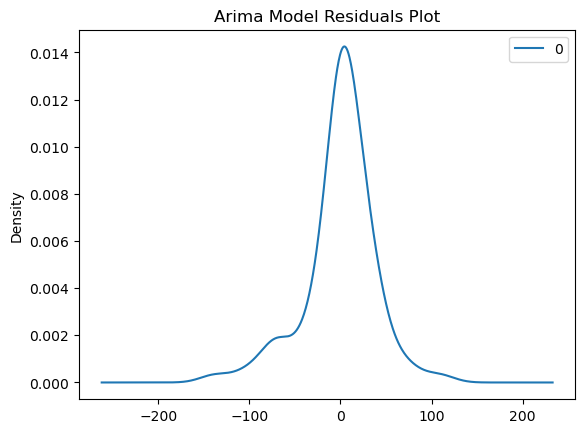

In [16]:
#Calculate the residuals form the arima model
residual=pd.DataFrame(model_fit.resid)

residual.plot(kind="kde")
plt.title("Arima Model Residuals Plot")
plt.show()

In [18]:
#forecasting using the arima model
# number of periods to forecast
forecast_periods = 12

#  forecasts
forecast = model_fit.forecast(steps=forecast_periods)

# Print the forecasts
print(f'Forecast for the next {forecast_periods} Days: {forecast}')


Forecast for the next 12 Days: 2021-06-25    0.018942
2021-06-26   -0.912946
2021-06-27   -1.798128
2021-06-28   -2.638946
2021-06-29   -3.437622
2021-06-30   -4.196269
2021-07-01   -4.916894
2021-07-02   -5.601401
2021-07-03   -6.251600
2021-07-04   -6.869213
2021-07-05   -7.455871
2021-07-06   -8.013126
Freq: D, Name: predicted_mean, dtype: float64


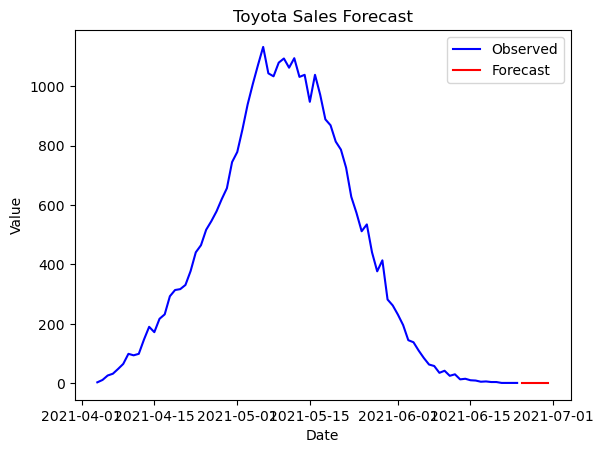

In [136]:
plt.plot(daily.index, daily.values, label='Observed', color='blue')

# Plot the forecasts
forecast_index = pd.date_range(start=daily.index[-1], periods=forecast_periods+1, freq='D')
plt.plot(forecast_index[1:], forecast, label='Forecast', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Toyota  Forecast')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [140]:
bmw=data[data["manufacturer"].str.lower()=="bmw"].copy()
bmw

bmw["posting_date"]=pd.to_datetime(bmw["posting_date"])
bmw["removal_date"]=pd.to_datetime(bmw["removal_date"])

bmw.sort_values(by="removal_date",inplace=True)
bmw.set_index('removal_date',inplace=True)
bmw

,Unnamed: 0,id,url,region,price,year,manufacturer,model,odometer,title_status,transmission,county,state,lat,long,posting_date,posting_to_removal_days
removal_date,,,,,,,,,,,,,,,,,
2021-04-04,416982,7301680179,https://eauclaire.craigslist.org/ctd/d/eau-cla...,eau claire,31950,2016.0,bmw,x5 xdrive35i awd suv,52902.0,clean,automatic,NaN,wi,44.843195,-91.550371,2021-04-04,0.0
2021-04-04,349020,7301711582,https://greenville.craigslist.org/ctd/d/greenv...,greenville / upstate,36990,2020.0,bmw,5 series 530i sedan 4d,35938.0,clean,other,NaN,sc,34.830000,-82.370000,2021-04-04,0.0
2021-04-04,59725,7301669391,https://santabarbara.craigslist.org/ctd/d/atla...,santa barbara,18990,2014.0,bmw,3 series 328i xdrive sedan,34227.0,clean,automatic,NaN,ca,33.786500,-84.445400,2021-04-04,0.0
2021-04-05,282453,7302198315,https://utica.craigslist.org/ctd/d/utica-2016-...,utica-rome-oneida,25990,2016.0,bmw,4 series 428i convertible 2d,54620.0,clean,other,NaN,ny,43.100000,-75.230000,2021-04-05,0.0
2021-04-05,341613,7301728866,https://york.craigslist.org/ctd/d/york-2017-bm...,york,36990,2017.0,bmw,x5 xdrive35i sport utility,23898.0,clean,other,NaN,pa,39.960000,-76.730000,2021-04-04,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-20,111453,7316693668,https://miami.craigslist.org/mdc/ctd/d/fort-la...,south florida,14988,2014.0,bmw,5 series,98560.0,clean,automatic,NaN,fl,26.176613,-80.135957,2021-05-04,47.0
2021-06-20,77946,7315325616,https://denver.craigslist.org/ctd/d/parker-200...,denver,6995,2006.0,bmw,530xi,179997.0,clean,automatic,NaN,co,39.532379,-104.768951,2021-05-01,50.0
2021-06-22,105070,7315229413,https://orlando.craigslist.org/cto/d/winter-sp...,orlando,5995,2006.0,bmw,325ci convertible,167590.0,clean,automatic,NaN,fl,28.681011,-81.256445,2021-05-01,52.0


In [21]:
daily_bmw=bmw.resample('D').size()
daily_bmw.count()


85

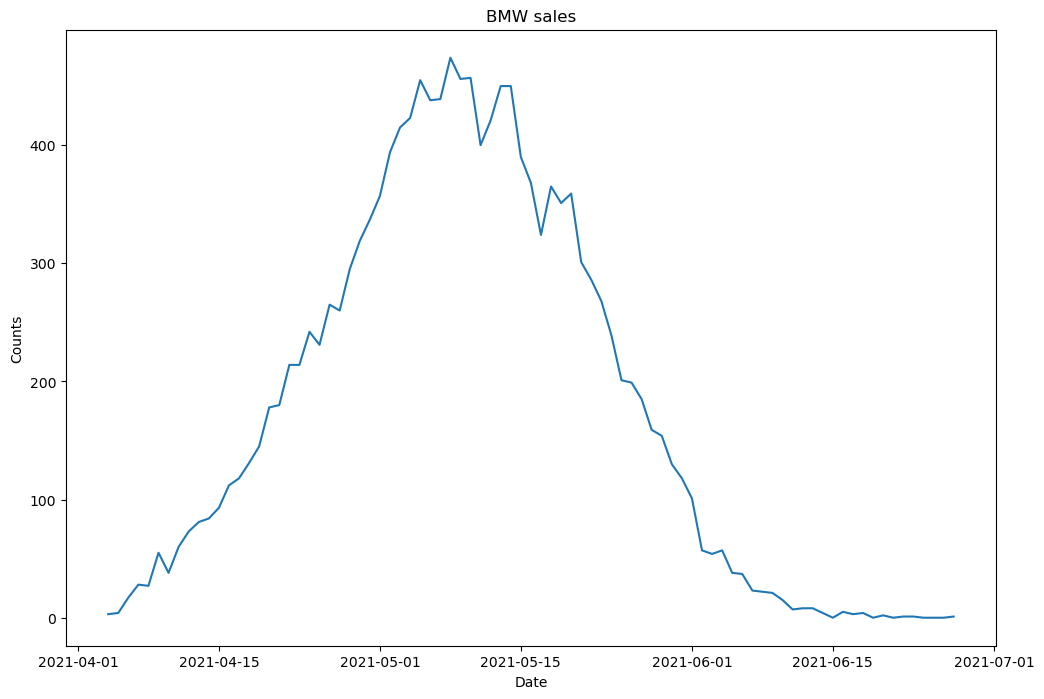

In [22]:
plt.figure(figsize=(12,8))
plt.plot(daily_bmw)
plt.title('BMW sales')
plt.xlabel('Date')
plt.ylabel('Counts')

plt.show()

In [23]:
#modelling
p,d,q=(1,1,1)
model=ARIMA(daily_bmw,order=(p,d,q))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   85
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -367.335
Date:                Sun, 29 Oct 2023   AIC                            740.670
Time:                        05:58:44   BIC                            747.963
Sample:                    04-04-2021   HQIC                           743.602
                         - 06-27-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9509      0.049     19.252      0.000       0.854       1.048
ma.L1         -0.8143      0.073    -11.180      0.000      -0.957      -0.672
sigma2       366.0406     40.511      9.036      0.000     286.641     445.440
===================================================================================
Ljung-Box (L1) (Q):                   3.44   Jarque-Bera (JB):                29.07
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

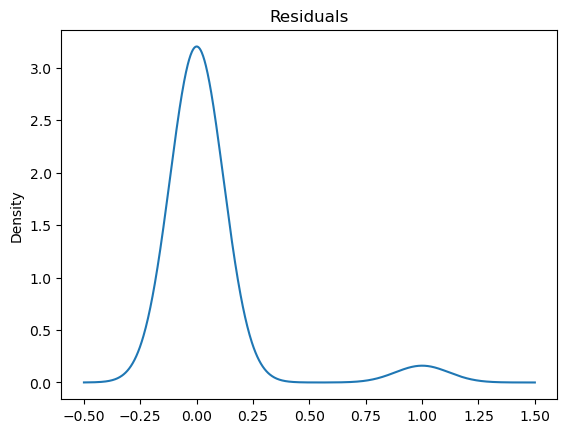

In [135]:

#get the residuals
residualB=model_fit.resid
residualB.plot(kind='kde')
plt.title('Residuals')
plt.show()

In [137]:
fc_period=12
forecast=model_fit.forecast(steps=fc_period)
print(forecast)

1970-01-22    1.0
1970-01-23    1.0
1970-01-24    1.0
1970-01-25    1.0
1970-01-26    1.0
1970-01-27    1.0
1970-01-28    1.0
1970-01-29    1.0
1970-01-30    1.0
1970-01-31    1.0
1970-02-01    1.0
1970-02-02    1.0
Freq: D, Name: predicted_mean, dtype: float64


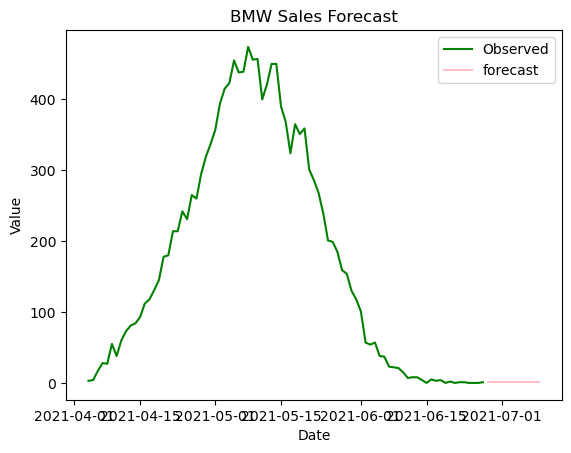

In [139]:
plt.plot(daily_bmw.index,daily_bmw.values,label='Observed',color='green')
fc_index=pd.date_range(start=daily_bmw.index[-1],periods=fc_period+1,freq='D')
plt.plot(fc_index[1:],forecast,label='forecast',color='pink')
plt.title('BMW Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [141]:
#TESLA
tesla=data[data["manufacturer"].str.lower()=="tesla"].copy()
tesla

tesla["posting_date"]=pd.to_datetime(tesla["posting_date"])
tesla["removal_date"]=pd.to_datetime(tesla["removal_date"])

tesla.sort_values(by="removal_date",inplace=True)
tesla.set_index('removal_date',inplace=True)
tesla

,Unnamed: 0,id,url,region,price,year,manufacturer,model,odometer,title_status,transmission,county,state,lat,long,posting_date,posting_to_removal_days
removal_date,,,,,,,,,,,,,,,,,
2021-04-06,314865,7302577664,https://corvallis.craigslist.org/ctd/d/corvall...,corvallis/albany,563,2013.0,tesla,model s base,34162.0,clean,automatic,NaN,or,44.575371,-123.259692,2021-04-06,0.0
2021-04-08,399922,7302777282,https://winchester.craigslist.org/ctd/d/manass...,winchester,40795,2018.0,tesla,model 3,24908.0,clean,automatic,NaN,va,38.762669,-77.461754,2021-04-06,2.0
2021-04-09,1806,7301654156,https://bham.craigslist.org/ctd/d/new-castle-2...,birmingham,29890,2013.0,tesla,model s,61591.0,clean,automatic,NaN,al,33.669601,-86.817617,2021-04-04,5.0
2021-04-09,406213,7302309255,https://moseslake.craigslist.org/ctd/d/spokane...,moses lake,946,2016.0,tesla,model x p90d awd,23945.0,NaN,automatic,NaN,wa,47.717677,-117.411665,2021-04-05,4.0
2021-04-10,96682,7304061666,https://fortmyers.craigslist.org/chl/ctd/d/for...,ft myers / SW florida,64990,2018.0,tesla,model x 75d sport utility,21637.0,clean,other,NaN,fl,26.630000,-81.850000,2021-04-09,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-07,408506,7316721033,https://seattle.craigslist.org/sno/ctd/d/seatt...,seattle-tacoma,28999,2012.0,tesla,model s performance,83530.0,clean,automatic,NaN,wa,47.757996,-122.346056,2021-05-04,34.0
2021-06-08,359086,7315842747,https://nashville.craigslist.org/ctd/d/nashvil...,nashville,58989,2015.0,tesla,model s,23906.0,clean,automatic,NaN,tn,36.138037,-86.731163,2021-05-02,37.0
2021-06-08,12988,7313493976,https://prescott.craigslist.org/ctd/d/prescott...,prescott,32990,2013.0,tesla,model s signature,62588.0,clean,other,NaN,az,34.620000,-112.420000,2021-04-27,42.0


In [144]:
daily_tesla=tesla.resample('D').size()
daily_tesla.count()

65

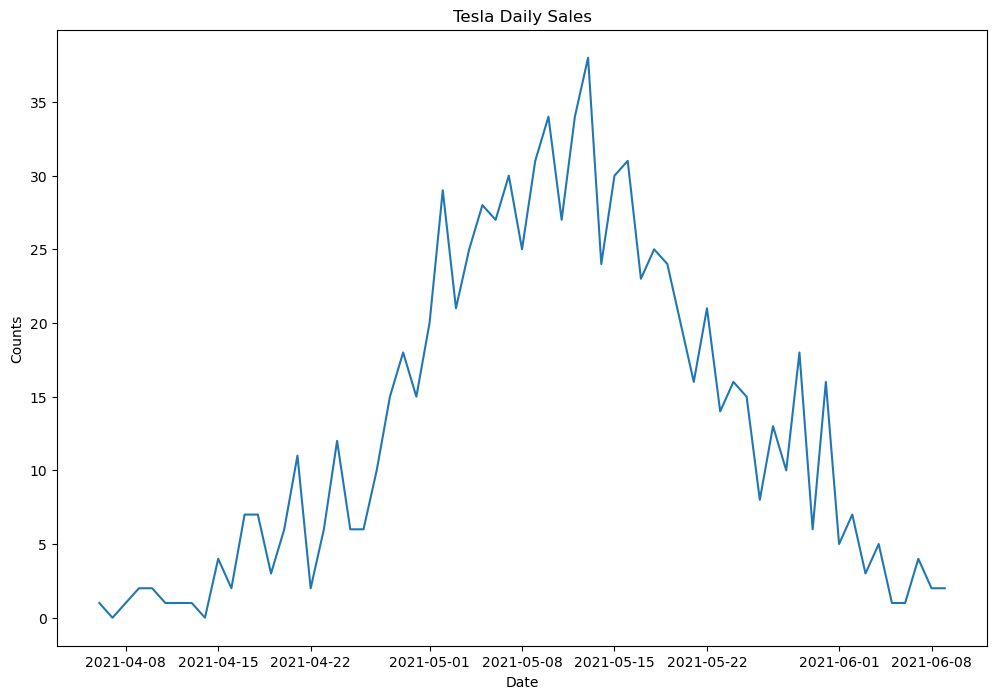

In [146]:
plt.figure(figsize=(12,8))
plt.plot(daily_tesla)
plt.title("Tesla Daily Sales")
plt.xlabel('Date')
plt.ylabel('Counts')
plt.show()

In [147]:
#modelling
p,d,q=(1,1,1)
model=ARIMA(daily_tesla,order=(p,d,q))
model_fit=model.fit()

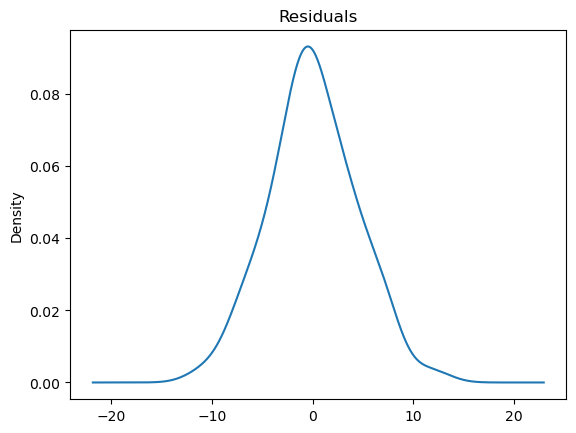

In [148]:
#Residuals
residuals=model_fit.resid
residuals.plot(kind='kde')
plt.title('Residuals')
plt.show()

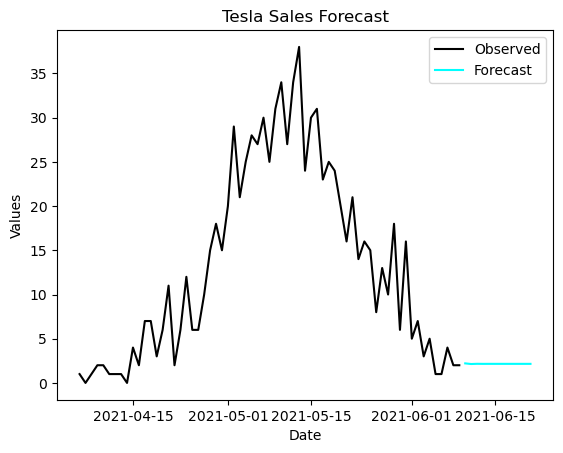

In [155]:

forecast_t=model_fit.forecast(steps=fc_period)
#Forecasting
plt.plot(daily_tesla.index,daily_tesla.values,label='Observed',color='black')

res_index=pd.date_range(start=daily_tesla.index[-1],periods=fc_period+1,freq='D')
plt.plot(res_index[1:],forecast_t,label='Forecast',color='cyan')
plt.title('Tesla Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [156]:
ford=data[data["manufacturer"].str.lower()=="ford"].copy()
ford

tesla["posting_date"]=pd.to_datetime(ford["posting_date"])
ford["removal_date"]=pd.to_datetime(ford["removal_date"])

ford.sort_values(by="removal_date",inplace=True)
ford.set_index('removal_date',inplace=True)
ford

,Unnamed: 0,id,url,region,price,year,manufacturer,model,odometer,title_status,transmission,county,state,lat,long,posting_date,posting_to_removal_days
removal_date,,,,,,,,,,,,,,,,,
2021-04-04,406949,7301719276,https://olympic.craigslist.org/ctd/d/puyallup-...,olympic peninsula,25999,2018.0,ford,escape,31115.0,clean,automatic,NaN,wa,47.199100,-122.315100,2021-04-04,0.0
2021-04-04,191689,7301593262,https://westernmass.craigslist.org/ctd/d/athol...,western massachusetts,8995,2013.0,ford,explorer 4x4,150000.0,clean,automatic,NaN,ma,42.571524,-72.158539,2021-04-04,0.0
2021-04-04,384305,7301611313,https://victoriatx.craigslist.org/ctd/d/victor...,victoria,12990,2015.0,ford,focus titanium hatchback 4d,100143.0,clean,other,NaN,tx,28.820000,-96.980000,2021-04-04,0.0
2021-04-05,229780,7302169073,https://missoula.craigslist.org/ctd/d/2014-for...,missoula,14900,2014.0,ford,explorer xlt 4x4,119470.0,rebuilt,automatic,NaN,mt,46.558592,-114.014173,2021-04-05,0.0
2021-04-05,134479,7301716739,https://eastidaho.craigslist.org/ctd/d/umatill...,east idaho,13995,2000.0,ford,super duty f-350 drw,235823.0,clean,automatic,NaN,id,45.876983,-119.293925,2021-04-04,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23,75818,7316687026,https://denver.craigslist.org/ctd/d/salt-lake-...,denver,41500,2007.0,ford,f-750,69829.0,clean,automatic,NaN,co,40.697700,-111.899000,2021-05-04,50.0
2021-06-24,324711,7313159848,https://roseburg.craigslist.org/cto/d/roseburg...,roseburg,5500,2012.0,ford,focus se,122000.0,clean,automatic,NaN,or,43.227000,-123.515800,2021-04-27,58.0
2021-06-24,147014,7316458806,https://stlouis.craigslist.org/ctd/d/east-sain...,"st louis, MO",13990,2008.0,ford,f350,83262.0,clean,automatic,NaN,il,38.566294,-90.134443,2021-05-03,52.0


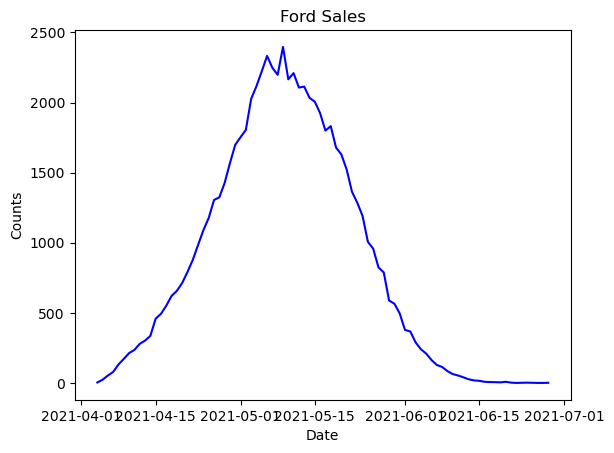

In [160]:
daily_ford=ford.resample('D').size()
plt.plot(daily_ford.index,daily_ford.values,color='blue')
plt.title('Ford Sales')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.show()

C:\New folder\CONDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\New folder\CONDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


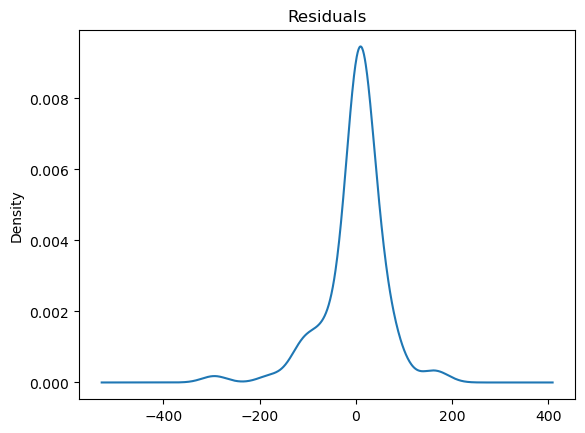

In [163]:
#modelling
p,d,q=(1,1,1)
model=ARIMA(daily_ford,order=(p,d,q))
model_fit=model.fit()

r=model_fit.resid
r.plot(kind='kde')
plt.title('Residuals')
plt.show()

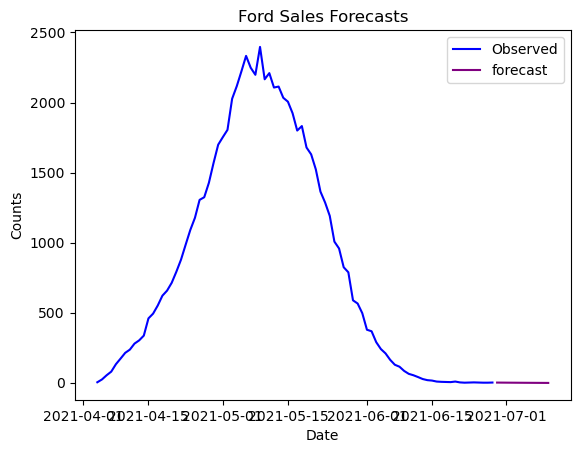

In [169]:
fore=model_fit.forecast(steps=fc_period)

plt.plot(daily_ford.index,daily_ford,label='Observed',color='blue')

residual_ind=pd.date_range(start=daily_ford.index[-1],periods=fc_period+1,freq='D')
plt.plot(residual_ind[1:],fore,label='forecast',color='purple')
plt.title('Ford Sales Forecasts')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.legend()
plt.show()

model

In [ ]:
daily.count()
manufacturer_data

In [ ]:
manufacturer_data.info()

In [27]:
data
print(data["manufacturer"])

0               bmw
1               bmw
2            toyota
3              ford
4              ford
            ...    
426875          NaN
426876         ford
426877    chevrolet
426878          NaN
426879        dodge
Name: manufacturer, Length: 426880, dtype: object


In [28]:
manufacturers = data['manufacturer']
manufacturers.unique()
# manufacturer_data= manufacturers[data['manufacturer'] == manufacturer]
# manufacturer_data.head(89)

array(['bmw', 'toyota', 'ford', 'honda', 'chrysler', 'buick', nan,
       'saturn', 'chevrolet', 'ram', 'jeep', 'nissan', 'dodge', 'gmc',
       'lincoln', 'kia', 'volkswagen', 'tesla', 'subaru', 'hyundai',
       'infiniti', 'mercedes-benz', 'mazda', 'cadillac', 'lexus',
       'mercury', 'volvo', 'acura', 'porsche', 'rover', 'audi', 'mini',
       'mitsubishi', 'jaguar', 'alfa-romeo', 'fiat', 'pontiac',
       'harley-davidson', 'datsun', 'ferrari', 'morgan', 'aston-martin',
       'land rover'], dtype=object)

In [133]:

# List of unique manufacturers
manufacturers = data['manufacturer'].unique()

# Create an empty dictionary to store results for each manufacturer
results = {}

# Set the forecast periods
forecast_periods = 6

for manufacturer in manufacturers:
    # Filter the data for the current manufacturer
    manufacturer_data = data[data['manufacturer'] == manufacturer].copy()

    # Check if there is data for the manufacturer
    if not manufacturer_data.empty:
        # Preprocess the data
        manufacturer_data['removal_date'] = pd.to_datetime(manufacturer_data['removal_date'])
        manufacturer_data.sort_values(by='removal_date', inplace=True)
        
        # Set the time series index with daily frequency
        manufacturer_data.index = pd.date_range(start=manufacturer_data.index[0], periods=len(manufacturer_data), freq='D')
        m=manufacturer_data.resample('D').size()
        # Check if the data is stationary (you can add your stationarity test here)

        # Fit an ARIMA model
        p, d, q = (1, 1, 1)
        model = ARIMA(m, order=(p, d, q))
        model_fit = model.fit()

        # Forecast future values
        forecast = model_fit.forecast(steps=forecast_periods)

        # Store the results for the current manufacturer
#         results[manufacturer] = {
#             'forecast': forecast
#         }

    else:
        print(f"No data found for manufacturer: {manufacturer}")

# Plot the forecasts for each manufacturer
for manufacturer, result in results.items():
    manufacturer_data = data[data['manufacturer'] == manufacturer]
    if not manufacturer_data.empty:
        plt.figure(figsize=(10, 6))
        plt.plot(m.index, m, label='Actual', color='blue')
        forecast_index = pd.date_range(start=m.index[-1], periods=forecast_periods + 1, freq='D', closed='right')
        plt.plot(forecast_index[1:],forecast, label='Forecast', color='red')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'Time Series Forecast for {manufacturer}')
        plt.legend()
        plt.show()
    else:
        print(f"No data found for manufacturer: {manufacturer}")


C:\New folder\CONDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\New folder\CONDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\New folder\CONDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\New folder\CONDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\New folder\CONDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization

No data found for manufacturer: nan


C:\New folder\CONDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\New folder\CONDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\New folder\CONDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\New folder\CONDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\New folder\CONDA\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization